This model generates the dose profile from an arbitrary activation profile. It is trained on patient-specific data from a set of N pencil beams.

In [34]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
import torch
import random
device = 'cpu'

In [17]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False # uses the inbuilt cudnn auto-tuner to find th
    torch.backends.cudnn.enabled = False
    return True

In [11]:
class DoseActivityDataset(Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        self.file_names = os.listdir(input_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Load activity and dose images (numpy arrays)
        input_volume = np.load(os.path.join(self.input_dir, self.file_names[idx]))
        output_volume = np.load(os.path.join(self.output_dir, self.file_names[idx]))

        # Convert numpy arrays to PyTorch tensors
        input_volume = torch.tensor(input_volume, dtype=torch.float32)
        output_volume = torch.tensor(output_volume, dtype=torch.float32)

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return input_volume, output_volume

In [10]:
def plot_examples(dataloader, num_examples=3):
    """
    Plot a few input-output image pairs side by side.

    Parameters:
    - dataloader: PyTorch DataLoader containing the image pairs
    - num_examples: Number of examples to plot (default is 5)
    """
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 3))
    
    # Load a batch of data
    inputs, outputs = next(iter(dataloader))
    
    for i in range(num_examples):
        # Convert tensors to numpy arrays for plotting
        input_img = inputs[i].numpy().transpose((1, 2, 0))
        output_img = outputs[i].numpy().transpose((1, 2, 0))

        # Plot input image
        axes[i, 0].imshow(input_img[:,30,:], cmap='jet' if input_img.shape[2] == 1 else None)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input')

        # Plot output image
        axes[i, 1].imshow(output_img[:,30,:], cmap='jet' if output_img.shape[2] == 1 else None)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Output')

    plt.tight_layout()
    plt.show()


In [12]:
# Create dataset
input_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/input"
output_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/output"
dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

torch.Size([4, 150, 60, 70]) torch.Size([4, 150, 60, 70])

Max. pixel value:  tensor(1.7197)
Min. pixel value:  tensor(0.)

Mean pixel value normalized: 0.002
Standard deviation of the normalized pixel values: 0.036


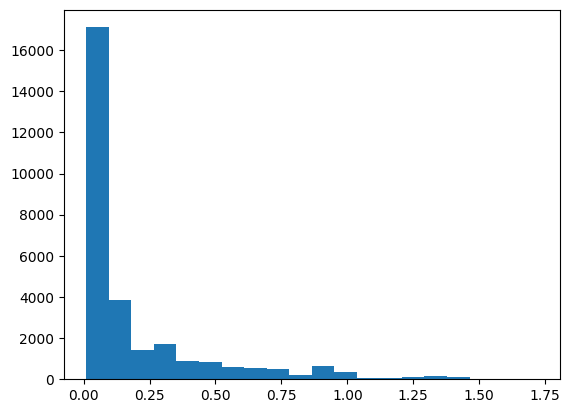

In [35]:
all_data = [x[0] for x in train_dataset]
all_data = torch.stack(all_data)
mean_value = all_data.mean()
std_value = all_data.std()
max_value = all_data.max()
min_value = all_data.min()

print('\nMax. pixel value: ', max_value)
print('Min. pixel value: ', min_value)

print(f'\nMean pixel value normalized: {mean_value:0.3f}')
print(f'Standard deviation of the normalized pixel values: {std_value:0.3f}')

data_flat = all_data.flatten().cpu().numpy()
plt.hist(data_flat[data_flat >0.01], bins=20)

transforms = Compose([#RandomRotation(10),
                      #RandAugment(),
                      #ToTensor(),
                      Normalize(mean_value, std_value)
                      ])

In [39]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

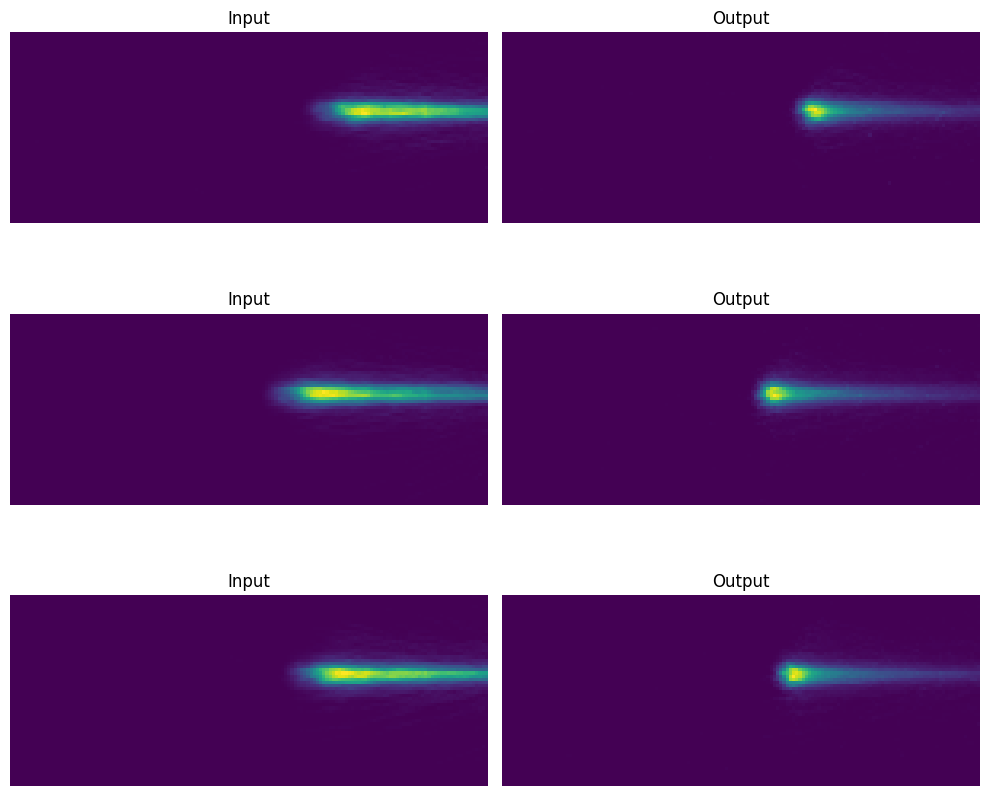

In [13]:
# Use the function
plot_examples(train_loader)

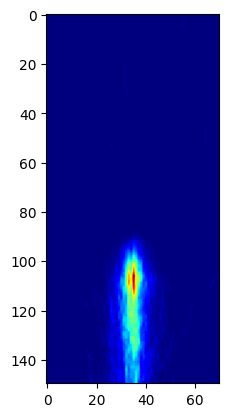

In [5]:
# Plot example binary image
plt.imshow(raw_image[:, 30, :], cmap='jet')